# Prepare data for AI training

This is an exploratory analysis of the PharmGKB data.

* Only PK-related data is considered.
* Only significant interactions are considered.
* Only compounds with a valid smiles are considered.

In [27]:
import pandas as pd
import numpy as np
import random
from rdkit import Chem
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import sys
from lol import LOL
from rdkit import RDLogger 
RDLogger.DisableLog('rdApp.*')

sys.path.append("../src")
from compound_structures import CompoundStructureEmbedding
from protein_sequences import ProteinSequenceEmbedding
from bioteque import BiotequeGeneEmbedding

In [36]:
df = pd.read_csv("../data/pharmgkb_processed/final_tables/pgkb_merged.csv", low_memory=False)
print("Compounds:", len(set(df["cid"])))
print("Genes:    ", len(set(df["gid"])))
print("Variants: ", len(set(df["vid"])))

Compounds: 1190
Genes:     1949
Variants:  6986


In [50]:
mychem = "doxycycline"

def mini_chemical_report(chemical):
    print("Genes")
    df_ = df[df["chemical"] == chemical]
    df_ = df_[df_["gene"].notnull()]
    gns = sorted(set(df_["gene"]))
    for gn in gns:
        print(gn)
    print(df_.head(5))    
    print(df_.shape[0])

mini_chemical_report(mychem)

Genes
G6PD
             cid     chemical  \
308372  PA449415  doxycycline   
308373  PA449415  doxycycline   

                                                   smiles      gid  gene  \
308372  C[C@@H]1[C@H]2[C@@H]([C@H]3[C@@H](C(=O)/C(=C(\...  PA28469  G6PD   
308373  C[C@@H]1[C@H]2[C@@H]([C@H]3[C@@H](C(=O)/C(=C(\...  PA28469  G6PD   

             ensembl_id          vid    variant evidence  significance  \
308372  ENSG00000160211  PA166157860  rs1050829      NaN           0.0   
308373  ENSG00000160211  PA166157859  rs1050828      NaN           0.0   

       phenotype  did disease biogroup  caid          vaid  
308372  Toxicity  NaN     NaN  Unknown   NaN  1.183705e+09  
308373  Toxicity  NaN     NaN  Unknown   NaN  1.183705e+09  
2


In [30]:
cid2smi = {}

for r in df[["cid", "smiles"]].values:
    if str(r[1]) != "nan":
        cid2smi[r[0]] = r[1]

cid2key = {}
for k,v in tqdm(cid2smi.items()):
    mol = Chem.MolFromSmiles(v)
    inchi = Chem.rdinchi.MolToInchi(mol)[0]
    inchikey = Chem.rdinchi.InchiToInchiKey(inchi)
    cid2key[k] = inchikey

100%|██████████| 904/904 [00:00<00:00, 3541.98it/s]


In [31]:
hp = pd.read_csv("../data/other/human_proteome_with_genenames.tab", sep="\t")
cols = list(hp.columns)
hp = hp[(hp[cols[0]].notnull()) & (hp[cols[2]].notnull())]
g2p = {}
for r in hp[[cols[0], cols[2]]].values:
    for x in r[1].split(" "):
        g2p[x] = r[0]

gid2key = {}
for r in df[["gid", "gene"]].values:
    if str(r[0]) == "nan" or str(r[1]) == "nan":
        continue
    if r[1] not in g2p:
        continue
    gid2key[r[0]] = g2p[r[1]]

In [35]:
mychem = "ivacaftor"

print(set(df[df["chemical"] == mychem]["gene"]))

{'CFTR', 'SLC26A9'}


In [40]:
mychem = "ivacaftor"

print(set(df[df["chemical"] == mychem]["vid"]))

{'PA166164956', 'PA166164953', 'PA166164943', 'PA166157529', 'PA166164946', 'PA166178138', 'PA166157531', 'PA166157533', 'PA166164944', 'PA166178021', 'PA166157525', 'PA166157532', 'PA166164948', 'PA166178060', 'PA166178058', 'PA166178088', 'PA166164958', 'PA166164959', 'PA166178049', 'PA166157530', 'PA166164950', 'PA166157534', 'PA166157516', 'PA166162981', 'PA166178065', 'PA166157537', 'PA166164949', 'PA166178067', 'PA166161186', 'PA166162695', 'PA166164957', 'PA166178063', 'PA166157519', 'PA166157518', 'PA166157521', 'PA166164947', 'PA166178193', 'PA166164945', 'PA166178052', 'PA166162705', 'PA166164939', 'PA166164940', 'PA166164941', 'PA166157511', 'PA166164952', 'PA166164955', 'PA166164951', 'PA166161188', 'PA166178032', nan, 'PA166164942', 'PA166178025'}


In [32]:
df["phenotype"].value_counts()

Metabolism/PK    123239
Toxicity          88571
Efficacy          75688
Dosage            34507
Other             12819
PD                  183
Name: phenotype, dtype: int64

In [11]:
df["significance"].value_counts()

 1.0    128558
-1.0     88453
 0.0     29906
Name: significance, dtype: int64

In [12]:
df = df[df["phenotype"].isin(["Metabolism/PK"])]#, "Toxicity", "Dosage"])]
df = df[df["significance"] != -1]
df = df[df["evidence"] != "4"]

In [13]:
df[df["significance"].isnull()].value_counts("evidence")

evidence
3     13618
1A    11969
2A      974
1B      461
2B        2
dtype: int64

In [14]:
df = df[["cid", "gid", "vid"]]
df = df.drop_duplicates()

In [15]:
triplets = set()
for r in df[["cid", "gid", "vid"]].values:
    r = tuple(r)
    if r[0] not in cid2key:
        continue
    if r[1] not in gid2key:
        continue
    triplets.update([(cid2key[r[0]], gid2key[r[1]], r[2])])
triplets = list(triplets)

pairs = set()
for r in df[["cid", "gid"]].values:
    r = tuple(r)
    if r[0] not in cid2key:
        continue
    if r[1] not in gid2key:
        continue
    pairs.update([(cid2key[r[0]], gid2key[r[1]])])
pairs = list(pairs)

In [19]:
print("Compound, Gene, Variant Triplets", len(triplets))
print("Compound, Gene Pairs", len(pairs))

Compound, Gene, Variant Triplets 16291
Compound, Gene Pairs 882


In [52]:
cemb = CompoundStructureEmbedding().get()
pemb = ProteinSequenceEmbedding().get()

In [53]:
class PairBalancer(object):

    def __init__(self, pairs):
        self.pairs = pairs

    def balanced_positives_negatives(self):
        x = list([x[0] for x in self.pairs])
        y = list([y[1] for y in self.pairs])
        random.shuffle(x)
        rand_pairs = [(x_, y_) for x_, y_ in zip(x, y)]
        all_pairs = self.pairs + rand_pairs
        y = [1]*len(self.pairs) + [0]*(len(all_pairs)-len(self.pairs))
        idxs = [i for i in range(len(y))]
        random.shuffle(idxs)
        all_pairs = [all_pairs[i] for i in idxs]
        y = [y[i] for i in idxs]
        return all_pairs, y

all_pairs, y = PairBalancer(pairs).balanced_positives_negatives()
print(len(all_pairs))

1764


In [21]:
df

,cid,gid,vid
17,PA451605,PA35844,PA166230183
25,PA449061,PA31591,PA166232961
29,PA450401,PA134991624,PA166233022
43,PA166163161,PA134865839,PA166154579
48,PA166186245,PA24696,PA166154482
...,...,...,...
329357,PA451690,PA128,PA166178882
329358,PA451690,PA128,PA166156076
329359,PA451690,PA128,PA166169720
329360,PA451690,PA128,PA166243646


In [54]:
class PairSplitter(object):

    def __init__(self, pairs, y=None):
        self.pairs = pairs
        self.y = y

    def random(self, test_size=0.2):
        idxs = [i for i in range(len(self.pairs))]
        random.shuffle(idxs)
        all_pairs = [self.pairs[i] for i in idxs]
        n = int(len(all_pairs)*(1-test_size))
        m = len(all_pairs) - n
        x_tr = all_pairs[:n]
        x_te = all_pairs[-m:]
        if self.y is not None:
            y = [self.y[i] for i in idxs]
            y_tr = y[:n]
            y_te = y[-m:]
            return x_tr, x_te, y_tr, y_te
        else:
            return x_tr, x_te

    def leave_drugs_out(self, test_size=0.2):
        uniq = list(set([x[0] for x in pairs]))
        random.shuffle(uniq)
        n = int(len(uniq)*(1-test_size))
        u_tr = set(uniq[:n])
        x_tr = []
        x_te = []
        y_tr = []
        y_te = []
        idxs = [i for i in range(len(self.pairs))]
        random.shuffle(idxs)
        all_pairs = [self.pairs[i] for i in idxs]
        if self.y is not None:
            y = [self.y[i] for i in idxs]
        else:
            y = None
        for i, p in enumerate(all_pairs):
            if p[0] in u_tr:
                x_tr += [p]
                if y is not None:
                    y_tr += [y[i]]
            else:
                x_te += [p]
                if y is not None:
                    y_te += [y[i]]
        if self.y is not None:
            return x_tr, x_te, y_tr, y_te
        else:
            return x_tr, x_te
        
    def leave_genes_out(self, test_size=0.2):
        uniq = list(set([x[1] for x in pairs]))
        random.shuffle(uniq)
        n = int(len(uniq)*(1-test_size))
        u_tr = set(uniq[:n])
        x_tr = []
        x_te = []
        y_tr = []
        y_te = []
        idxs = [i for i in range(len(self.pairs))]
        random.shuffle(idxs)
        all_pairs = [self.pairs[i] for i in idxs]
        if self.y is not None:
            y = [self.y[i] for i in idxs]
        else:
            y = None
        for i, p in enumerate(all_pairs):
            if p[1] in u_tr:
                x_tr += [p]
                if y is not None:
                    y_tr += [y[i]]
            else:
                x_te += [p]
                if y is not None:
                    y_te += [y[i]]
        if self.y is not None:
            return x_tr, x_te, y_tr, y_te
        else:
            return x_tr, x_te

    def leave_my_drugs_out(self, interest_list):
        pass

    def leave_my_targets_out(self, interest_list):
        pass


pairs_tr, pairs_te, y_tr, y_te = PairSplitter(all_pairs, y).leave_drugs_out(0.2)


In [20]:
triplets

[('RZTAMFZIAATZDJ-UHFFFAOYSA-N', 'P20815', 'PA166157492'),
 ('AHOUBRCZNHFOSL-YOEHRIQHSA-N', 'P10635', 'PA166274893'),
 ('TXUZVZSFRXZGTL-QPLCGJKRSA-N', 'P10635', 'PA166243646'),
 ('LNEPOXFFQSENCJ-UHFFFAOYSA-N', 'P10635', 'PA166156149'),
 ('YASAKCUCGLMORW-UHFFFAOYSA-N', 'P10632', 'PA166242941'),
 ('TVYLLZQTGLZFBW-ZBFHGGJFSA-N', 'P10635', 'PA166156233'),
 ('TXUZVZSFRXZGTL-QPLCGJKRSA-N', 'P10635', 'PA166274895'),
 ('RAPZEAPATHNIPO-UHFFFAOYSA-N', 'P10635', 'PA166156242'),
 ('VHGCDTVCOLNTBX-QGZVFWFLSA-N', 'P10635', 'PA166156152'),
 ('RYMZZMVNJRMUDD-HGQWONQESA-N', 'P08684', 'PA166242041'),
 ('YEEZWCHGZNKEEK-UHFFFAOYSA-N', 'P11712', 'PA166183295'),
 ('LDJVNWFKNMYYNT-FYWRMAATSA-N', 'P11712', 'PA166219768'),
 ('USSIQXCVUWKGNF-UHFFFAOYSA-N', 'P20815', 'PA166157484'),
 ('YELGFTGWJGBAQU-UHFFFAOYSA-N', 'P10635', 'PA166274893'),
 ('ADEBPBSSDYVVLD-UHFFFAOYSA-N', 'P10635', 'PA166156180'),
 ('ZNRGQMMCGHDTEI-UHFFFAOYSA-N', 'P10635', 'PA166251205'),
 ('USSIQXCVUWKGNF-UHFFFAOYSA-N', 'P05177', 'PA166157966'

In [55]:

from sklearn.ensemble import RandomForestClassifier


class BimodalStackedModel(object):

    def __init__(self, df_A, df_B):
        self.dict_A = dict((r[0], r[1:]) for r in df_A.values)
        self.dict_B = dict((r[0], r[1:]) for r in df_B.values)
        self.reducer = LOL(n_components=100)
        self.model = RandomForestClassifier()

    def fit(self, pairs, y):
        y = np.array(y)
        A = []
        B = []
        y_ = []
        for i, t in enumerate(pairs):
            if t[0] not in self.dict_A:
                continue
            if t[1] not in self.dict_B:
                continue
            A += [self.dict_A[t[0]]]
            B += [self.dict_B[t[1]]]
            y_ += [y[i]]
        A = np.array(A)
        B = np.array(B)
        X = np.hstack([A, B])
        y = np.array(y_).astype(int)
        self.reducer.fit(X, y)
        X = self.reducer.transform(X)
        self.model.fit(X, y)

    def predict(self, pairs):
        A = []
        B = []
        idxs = []
        for i, t in enumerate(pairs):
            if t[0] not in self.dict_A:
                continue
            if t[1] not in self.dict_B:
                continue
            A += [self.dict_A[t[0]]]
            B += [self.dict_B[t[1]]]
            idxs += [i]
        A = np.array(A)
        B = np.array(B)
        X = np.hstack([A, B])
        X = self.reducer.transform(X)
        y_ = self.model.predict_proba(X)[:,1]
        y_hat = np.full((len(pairs),), np.nan)
        y_hat[idxs] = y_
        return y_hat
    
    def evaluate(self, pairs, y):
        y_hat = self.predict(pairs)
        idxs = [i for i in range(len(y_hat)) if not np.isnan(y_hat[i])]
        y_hat = [y_hat[i] for i in idxs]
        y = [y[i] for i in idxs]
        return roc_auc_score(y, y_hat)
    
mdl = BimodalStackedModel(cemb, pemb)

mdl.fit(pairs_tr, y_tr)
mdl.evaluate(pairs_te, y_te)

0.5586413961343593

In [56]:
bge = BiotequeGeneEmbedding()
pse = ProteinSequenceEmbedding()
cse = CompoundStructureEmbedding()

In [57]:
cemb_list = []
for x in cse.available():
    cemb_list += [(x, CompoundStructureEmbedding(x).get())]

pemb_list = []
for x in pse.available():
    pemb_list += [(x, ProteinSequenceEmbedding(x).get())]

for x in bge.available().values:
    pemb_list += [(x, BiotequeGeneEmbedding(x[0], x[1]).get())]

In [58]:
R = []
for cemb in cemb_list:
    for pemb in pemb_list:
        model = BimodalStackedModel(cemb[1], pemb[1])
        model.fit(pairs_tr, y_tr)
        print(cemb[0], pemb[0], model.evaluate(pairs_te, y_te))
        R += [model.predict(pairs_te)]

ersilia esm1b 0.5660536686057422
ersilia prot5 0.5450600487896415
ersilia ['GEN-pdf-TIS' 'hpa_proteome'] 0.6181554103122731
ersilia ['GEN-ass-PWY' 'reactome'] 0.582785570105067
ersilia ['GEN-cex-GEN' 'coexpressdb'] 0.5686554532952501
ersilia ['GEN-has-DOM' 'interpro'] 0.5805011520737328
ersilia ['GEN-pab-TIS' 'hpa_proteome'] 0.5874095196314981
ersilia ['GEN-has-MFN' 'gomf_goa_curated'] 0.569848167016282
ersilia ['GEN-upr-CLL' 'gdsc1000_mrna'] 0.5633004499826929
ersilia ['GEN-ppi-GEN' 'hi_union'] 0.36403508771929827
ersilia ['GEN-ppi-GEN' 'string'] 0.5604885057471265
ersilia ['GEN-ass-DIS' 'opentargets'] 0.5691861330159202
ersilia ['GEN-ass-DIS' 'disgenet_curated'] 0.5643796992481203
ersilia ['GEN-has-CMP' 'jensencompartmentcurated'] 0.5212366230677764
signaturizer esm1b 0.6270495756172839
signaturizer prot5 0.6080970293209876
signaturizer ['GEN-pdf-TIS' 'hpa_proteome'] 0.6824661963550852
signaturizer ['GEN-ass-PWY' 'reactome'] 0.6058926954019926
signaturizer ['GEN-cex-GEN' 'coexpressdb

In [59]:
y_hat = np.array(R)
y_hat = np.nanpercentile(y_hat, 75, axis=0)

idxs = [i for i in range(len(y_hat)) if not np.isnan(y_hat[i])]
y_hat = [y_hat[i] for i in idxs]
y_ = [y_te[i] for i in idxs]
roc_auc_score(y_, y_hat)

/Users/mduranfrigola/miniconda3/envs/biogpt/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


0.641747982735973

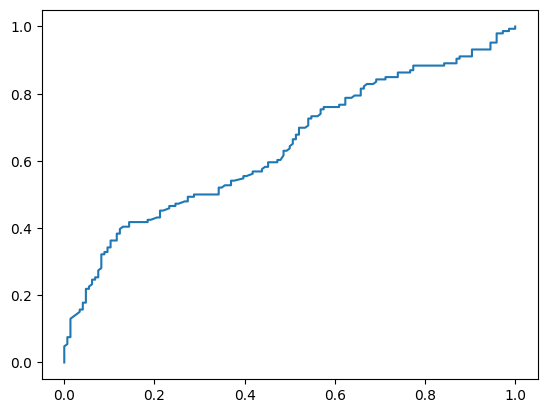

In [60]:
%matplotlib inline
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_, y_hat)
plt.plot(fpr, tpr)